In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
nltk.download('punkt','./data')


[nltk_data] Downloading package punkt to ./data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_path = "./twitter_data/train.csv"
test_path = "./twitter_data/test.csv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
test_df

,Id,Category
0,6.289494e+17,dear @Microsoft the newOoffice for Mac is grea...
1,6.289766e+17,@Microsoft how about you make a system that do...
2,6.290232e+17,Not Available
3,6.291792e+17,Not Available
4,6.291863e+17,If I make a game as a #windows10 Universal App...
...,...,...
9963,NaN,NaN
9964,NaN,NaN
9965,NaN,NaN
9966,NaN,NaN


In [3]:
def preprocess(df, mode='train'):
    if mode=='test':
        df=df.rename(columns={"Category": "Tweet"})
        
    
    df = df.drop(columns=["Id"])
    df = df.dropna()
    df = df[df['Tweet'] != "Not Available"]
    return df

In [4]:
test_df_p=preprocess(test_df,'test') # has no labels!
train_df_p=preprocess(train_df,'train')


In [5]:
def undersample(train_df):
    remove_pos = 2599 - 869
    remove_neut = 1953 - 869

    neg_df = train_df[train_df["Category"] == "negative"] 

    pos_df = train_df[train_df["Category"] == "positive"]
    neut_df = train_df[train_df["Category"] == "neutral"]

    pos_drop_indices = np.random.choice(pos_df.index, remove_pos, replace=False)
    neut_drop_indices = np.random.choice(neut_df.index, remove_neut, replace=False)

    pos_undersampled = pos_df.drop(pos_drop_indices)
    neut_undersampled = neut_df.drop(neut_drop_indices)
    balanced_train_df = pd.concat([neg_df, pos_undersampled, neut_undersampled])
    
    return balanced_train_df

    
    

In [6]:
u_balanced_train=undersample(train_df_p)

In [7]:
def tts(balanced_train_df):
    
    train_clean_df, test_clean_df = train_test_split(balanced_train_df, test_size=0.15)
    
    return train_clean_df, test_clean_df

    

In [8]:
    train_clean_df, test_clean_df=tts(u_balanced_train)

In [9]:
def remove_links_mentions(tweet):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

In [10]:
train_set = list(train_clean_df.to_records(index=False))
test_set = list(test_clean_df.to_records(index=False))
train_set = [(label, word_tokenize(remove_links_mentions(tweet))) for label, tweet in train_set]
test_set = [(label, word_tokenize(remove_links_mentions(tweet))) for label, tweet in test_set]

In [11]:
def create_vocab(train_set, test_set):
    index2word = ["<PAD>", "<SOS>", "<EOS>"]

    for ds in [train_set, test_set]:
        for label, tweet in ds:
            for token in tweet:
                if token not in index2word:
                    index2word.append(token)
    return index2word

In [12]:
index2word=create_vocab(train_set, test_set)
word2index = {token: idx for idx, token in enumerate(index2word)}


In [13]:
def label_map(label):
    if label == "negative":
        return 0
    elif label == "neutral":
        return 1
    else: #positive
        return 2

In [14]:
seq_length = 32
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [15]:
train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in train_set]
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test_set]


In [16]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [17]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [24]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
epochs = 120
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

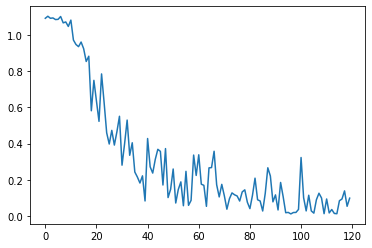

In [25]:
plt.plot(losses)


In [29]:
torch.save(model,"./models/lstm")

IsADirectoryError: [Errno 21] Is a directory: './models/lstm'